In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif

from funs import plotDictionary, chi2_independence, highlightTable

In [3]:
# Data Collection

# Raw Data
all_trxns = pd.read_csv("../all_trxns.csv", dtype={'counterparty': str})

# Exchange Rates -> more info in currencies.ipynb
currency_rates = pd.read_csv("../exchange_rates.csv", header=None, names=["ccy", "date", "rate"])

In [4]:
# Data Cleaning and Preprocessing

# Get as many factors as possible

# Transform the variables and provide additional features
trxns_data = all_trxns.copy()
# Convert the timestamp to datetime
trxns_data['timestamp'] = pd.to_datetime(trxns_data['timestamp'], infer_datetime_format=True)
# Add the date and the exchange rate
trxns_data['date'] = trxns_data['timestamp'].dt.date
trxns_data = trxns_data.merge(currency_rates, on=['ccy', 'date'], how='left')
trxns_data['rate'] = np.where(trxns_data['rate'].isna(), 1, trxns_data['rate'])
# Clean and convert the amount to EUR
trxns_data['amount'] = trxns_data['amount'].apply(lambda x: float(re.sub('[^0-9.]', '', x)))
trxns_data['amount_eur'] = trxns_data['amount'] / trxns_data['rate']
# Extract the customer type from the customer id
trxns_data['customer_type'] = trxns_data['customer'].str[0]
# Extract the weekday, month, quarter and hour from the timestamp
trxns_data['weekday'] = trxns_data['date'].apply(lambda x: x.strftime('%A'))
trxns_data['month'] = trxns_data['date'].apply(lambda x: x.strftime('%B'))
trxns_data['quarter'] = trxns_data['date'].apply(lambda x: 'Q'+str((x.month-1)//3+1))
trxns_data['hour'] = trxns_data['timestamp'].dt.hour
# Replace missing values in the "counterparty_country" column with "unknown"
trxns_data['counterparty_country'] = np.where(trxns_data['counterparty_country'].isna(), "unknown", trxns_data['counterparty_country'])

# Calculate the thresholds for the equally sized buckets of the amount in EUR
amount_eur_quantile = np.quantile(trxns_data['amount_eur'], q=np.arange(0, 1.2, 0.2))

# Add amount_eur buckets
trxns_data['amount_eur_bucket'] = pd.cut(trxns_data['amount_eur'], bins=amount_eur_quantile, include_lowest=True)

C:\Users\Mateusz\AppData\Local\Temp\ipykernel_27124\263349103.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['count'] = 1


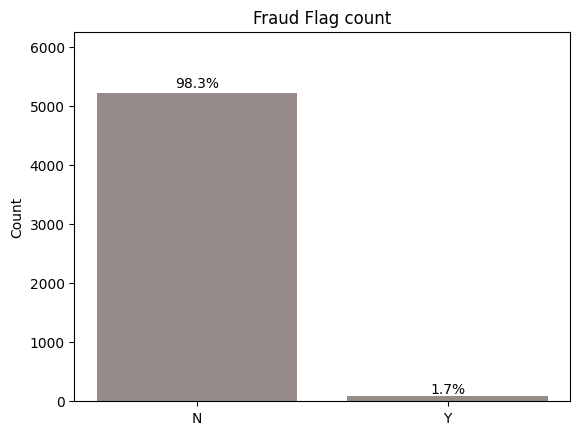

In [5]:
# Fraud Flag plot

# How many frauds are there?

# Prepare plot data
plot_data = trxns_data[['fraud_flag']]
plot_data['count'] = 1
summary = plot_data.groupby('fraud_flag').count()
summary['perc'] = summary['count'] / summary['count'].sum()

# Plot the data
fig, ax = plt.subplots()
bars = ax.bar(summary.index, summary['count'], color='#968B89')
ax.set_title('Fraud Flag count')
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.set_ylim(top=summary['count'].max() * 1.2)

# Add the percentage on top of the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height * 1.01, f'{summary["perc"][i]:.1%}', ha='center', va='bottom')

plt.show()

In [ ]:
# in total there is 1.7% probability of a transaction being a fraud
# it would be good to identify the variable that is associated with the fraud flag
# or to find a factor within a variable that is associated with the fraud flag

In [11]:
# Which variables could be associated with the fraud flag?

chi2_independence(trxns_data, 'ccy', 'fraud_flag', type = 'description')

# after going through all the variables, i think it does not make sense to use the variables in the current state as probably the model would not be able to generalize well

Chi-square statistic:  44.16721635437049
p-value:  5.290285692905754e-07
Degrees of freedom:  8
Expected frequencies: 
ccy               BRL         CNY         EUR          GBP         HKD  \
fraud_flag                                                               
N           312.54206  382.323463  579.873633  1170.558469  319.421916   
Y             5.45794    6.676537   10.126367    20.441531    5.578084   

ccy                INR        JPY         SGD          USD  
fraud_flag                                                  
N           242.760656  371.51226  815.754432  1016.253112  
Y             4.239344    6.48774   14.245568    17.746888  


In [12]:
# Is it possible to identify factor within a variable that is associated with the fraud flag?
# values with the * are the ones that have values significantly different than expected

highlightTable(trxns_data, 'ccy', 'fraud_flag')

# there are a lot of factors within the variables that could be used to identify the fraud flag because the values are significantly different than expected

ccy,BRL,CNY,EUR,GBP,HKD,INR,JPY,SGD,USD
fraud_flag,,,,,,,,,
N,312,367,585,1176,324,242,372,815,1018
Y,6,22*,5,15,1,5,6,15,16


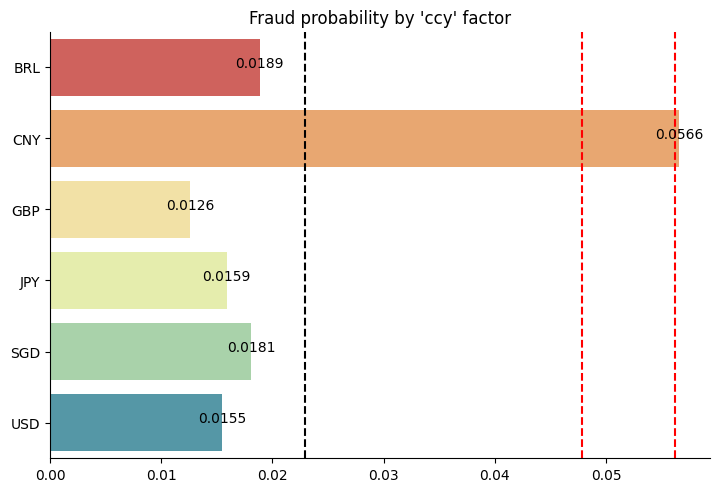

In [13]:
# How does it look on the plot?
#
# black dashed line is the mean value 
# red dashed lines are the values of mean plus 1.5 and 2 standard deviations
# red solid line is the value of quantile (by default 0.9) plus standard deviation

plotDictionary(trxns_data, colname = 'ccy', quantile_threshold = .9, count_filter = 5)

In [17]:
# Get all the factors from the variables as separate variables
# and analyze their association with the fraud flag
#
# One hot encoding and ANOVA f-test

# https://machinelearningmastery.com/feature-selection-with-numerical-input-data/#:~:text=ANOVA%20f%2Dtest%20Feature%20Selection

# Select the features
feature_names = ["customer_country", "counterparty_country", "type", "ccy", "customer_type", "weekday", "month", "quarter", "hour", "amount_eur_bucket"]

# Split the data into features (X) and target (y)
X = trxns_data[feature_names]
y = trxns_data['fraud_flag']

# Perform one-hot encoding
X_encoded = pd.get_dummies(X, columns=feature_names)

# Define the number of top features to select
k = 50

# Perform univariate feature selection using ANOVA F-value
selector = SelectKBest(f_classif, k=k)
selector.fit(X_encoded, y)

# Get the scores and p-values of each feature
scores = selector.scores_
pvalues = selector.pvalues_

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'feature': X_encoded.columns,
    'score': scores,
    'pvalue': pvalues
})

# Sort the results by score in descending order
results_df = results_df.sort_values(by='score', ascending=False)

# Filter out the features with pvalue less or equal to 0.01
results_df = results_df[results_df['pvalue'] <= 0.01]

# Print the top k features and their scores
print(results_df.head(k))

                                    feature      score        pvalue
21                             type_PAYMENT  73.624405  1.225702e-17
25                                  ccy_CNY  38.885269  4.842681e-10
9                   counterparty_country_JP  30.765566  3.052713e-08
35                          customer_type_P  30.489511  3.516585e-08
73                                  hour_13  19.631395  9.580562e-06
40                           weekday_Sunday  17.347717  3.162185e-05
53                           month_November  13.523695  2.379037e-04
86  amount_eur_bucket_(43377.466, 62376.65]  12.190181  4.843339e-04
33                          customer_type_C  11.684473  6.349856e-04
51                              month_March  10.310940  1.330337e-03
63                                   hour_3   9.560922  1.997962e-03
18                            type_INTEREST   9.044535  2.647180e-03
16                             type_BILLING   8.011065  4.666738e-03
17                            type

In [ ]:
# For the purpose of this exercise, i think that the data is good enough to be used for the model